In [ ]:
import os
import pandas as pd
import multiprocessing
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers, callbacks
import numpy as np
import hashlib
import matplotlib.pyplot as plt


# Data Loading

In [ ]:
SPLITS_ID = 1
BATCH_SIZE = 64
WIDTH = 224
HEIGHT = 224
SEED = 4

In [ ]:
DATASET_PATH = '/kaggle/input/data-car-public/Public'
SPLITS_PATH = '/kaggle/input/cardataset-splits/cardataset_splits'

In [ ]:
train_csv = os.path.join(SPLITS_PATH, f"CarDataset-Splits-{SPLITS_ID}-Train.csv")
test_csv = os.path.join(SPLITS_PATH, f"CarDataset-Splits-{SPLITS_ID}-Test.csv")

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)


train_df["ImageFullPath"] = train_df["ImageFullPath"].apply(lambda x: os.path.join(DATASET_PATH, x))
test_df["ImageFullPath"] = test_df["ImageFullPath"].apply(lambda x: os.path.join(DATASET_PATH, x))

train_df["CategoryID"] = train_df["CategoryID"].astype(str)
test_df["CategoryID"] = test_df["CategoryID"].astype(str)

# Preprocessing

In [ ]:
# Kiểm tra xem các đường dẫn ảnh có tồn tại không
def check_image_paths(df):
    """Kiểm tra xem các đường dẫn ảnh có tồn tại không."""
    df['Exists'] = df['ImageFullPath'].apply(lambda x: os.path.exists(os.path.join(DATASET_PATH, x)))
    missing_images = df[~df['Exists']]
    if not missing_images.empty:
        print(f"Missing {len(missing_images)} images:")
        print(missing_images['ImageFullPath'].tolist())
    else:
        print("All images are available.")
    return df[df['Exists']]

train_df = check_image_paths(train_df)
test_df = check_image_paths(test_df)

Missing 34 images:
['/kaggle/input/data-car-public/Public/Mazda/22520779-22521587.Mazda.143 (1).jpg', '/kaggle/input/data-car-public/Public/Mazda/22520779-22521587.Mazda.146 (1).jpg', '/kaggle/input/data-car-public/Public/Mazda/22520779-22521587.Mazda.148 (1).jpg', '/kaggle/input/data-car-public/Public/Mazda/22520779-22521587.Mazda.145 (1).jpg', '/kaggle/input/data-car-public/Public/Mazda/22520779-22521587.Mazda.147 (1).jpg', '/kaggle/input/data-car-public/Public/Mazda/22520779-22521587.Mazda.149 (1).jpg', '/kaggle/input/data-car-public/Public/Mazda/22520779-22521587.Mazda.144 (1).jpg', '/kaggle/input/data-car-public/Public/Mitsubishi/22521586-22521559.Mitsubishi.156 (1).jpg', '/kaggle/input/data-car-public/Public/Mitsubishi/22521586-22521559.Mitsubishi.157 (1).jpg', '/kaggle/input/data-car-public/Public/Mitsubishi/22521586-22521559.Mitsubishi.158 (1).jpg', '/kaggle/input/data-car-public/Public/Mitsubishi/22521586-22521559.Mitsubishi.159 (1).jpg', '/kaggle/input/data-car-public/Public/

In [ ]:
train_df.drop(columns=['Exists'], inplace=True)
test_df.drop(columns=['Exists'], inplace=True)

In [ ]:
# Xóa các ảnh trùng lặp trong tập train - lấy kết quả từ clustering
duplicate = pd.read_csv('/kaggle/input/car-duplicateimages/DuplicateImages-Splits-1.csv')
duplicate['Image2'] = duplicate['Image2'].apply(lambda x: os.path.join(DATASET_PATH, x))

duplicate_paths = duplicate.iloc[:, 1].unique().tolist()

In [ ]:
train_df = train_df[~train_df['ImageFullPath'].isin(duplicate_paths)]
train_df

,ImageFullPath,CategoryID
0,/kaggle/input/data-car-public/Public/Mazda/225...,4
1,/kaggle/input/data-car-public/Public/Mazda/225...,4
2,/kaggle/input/data-car-public/Public/Mazda/225...,4
3,/kaggle/input/data-car-public/Public/Mazda/225...,4
4,/kaggle/input/data-car-public/Public/Mazda/225...,4
...,...,...
27854,/kaggle/input/data-car-public/Public/Honda/225...,1
27855,/kaggle/input/data-car-public/Public/Honda/225...,1
27857,/kaggle/input/data-car-public/Public/Honda/225...,1
27859,/kaggle/input/data-car-public/Public/Honda/225...,1


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Chia dữ liệu theo tỷ lệ lớp
train_data, val_data = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['CategoryID'],  # Đảm bảo phân phối lớp đồng đều
    random_state=SEED
)

# Khởi tạo ImageDataGenerator
train_data_generator = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,          # Xoay ngẫu nhiên
    width_shift_range=0.1,      # Dịch chuyển ngang
    height_shift_range=0.1,     # Dịch chuyển dọc
    shear_range=0.1,            # Biến dạng hình học
    zoom_range=0.2,             # Phóng to / thu nhỏ
    horizontal_flip=True,       # Lật ngang
    fill_mode='nearest'         # Điền các pixel trống bằng giá trị pixel gần nhất
)

test_data_generator = ImageDataGenerator(
    rescale=1/255
)

# Cấu hình chung
dataframe_config = {
    'x_col': 'ImageFullPath',
    'y_col': 'CategoryID',
    'target_size': (HEIGHT, WIDTH),
    'batch_size': BATCH_SIZE,
    'class_mode': 'categorical',
    'shuffle': True,
    'seed': SEED,
    'color_mode': 'rgb',
}

# Flow từ DataFrame
train_generator = train_data_generator.flow_from_dataframe(train_data, **dataframe_config)
val_generator = train_data_generator.flow_from_dataframe(val_data, **dataframe_config)
test_generator = test_data_generator.flow_from_dataframe(test_df, **dataframe_config)


Found 19920 validated image filenames belonging to 9 classes.
Found 4981 validated image filenames belonging to 9 classes.
Found 6960 validated image filenames belonging to 9 classes.


In [ ]:
import numpy as np

def check_data_distribution(generator, name):
    # Truy cập các nhãn được gán trong generator
    labels = generator.classes  # Danh sách chỉ số lớp cho mỗi mẫu
    unique, counts = np.unique(labels, return_counts=True)  # Đếm số lượng mẫu mỗi lớp

    # Truy cập tên lớp
    class_names = list(generator.class_indices.keys())  # Danh sách tên các lớp
    distribution = dict(zip(class_names, counts))  # Ghép tên lớp và số lượng mẫu

    print(f"Data Distribution in {name}:")
    for cls, count in distribution.items():
        print(f"  {cls}: {count}")
    print("\n")
    return distribution

# Kiểm tra phân phối trên từng generator
train_distribution = check_data_distribution(train_generator, "Train Generator")
val_distribution = check_data_distribution(val_generator, "Validation Generator")
test_distribution = check_data_distribution(test_generator, "Test Generator")


Data Distribution in Train Generator:
  0: 2479
  1: 1703
  2: 1928
  3: 1649
  4: 1969
  5: 1770
  6: 3900
  7: 3356
  8: 1166


Data Distribution in Validation Generator:
  0: 620
  1: 426
  2: 482
  3: 412
  4: 492
  5: 443
  6: 975
  7: 839
  8: 292


Data Distribution in Test Generator:
  0: 791
  1: 605
  2: 652
  3: 673
  4: 666
  5: 597
  6: 1333
  7: 1184
  8: 459




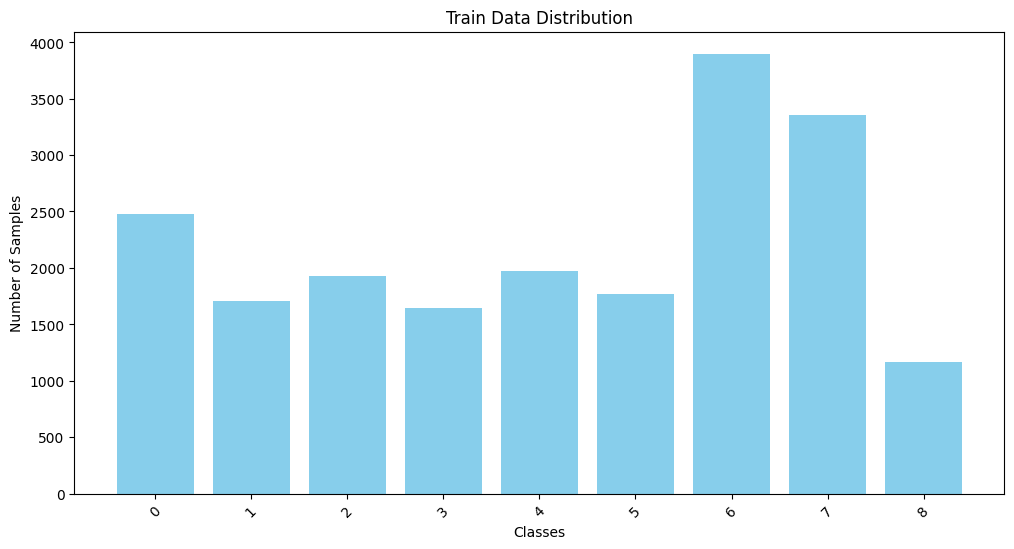

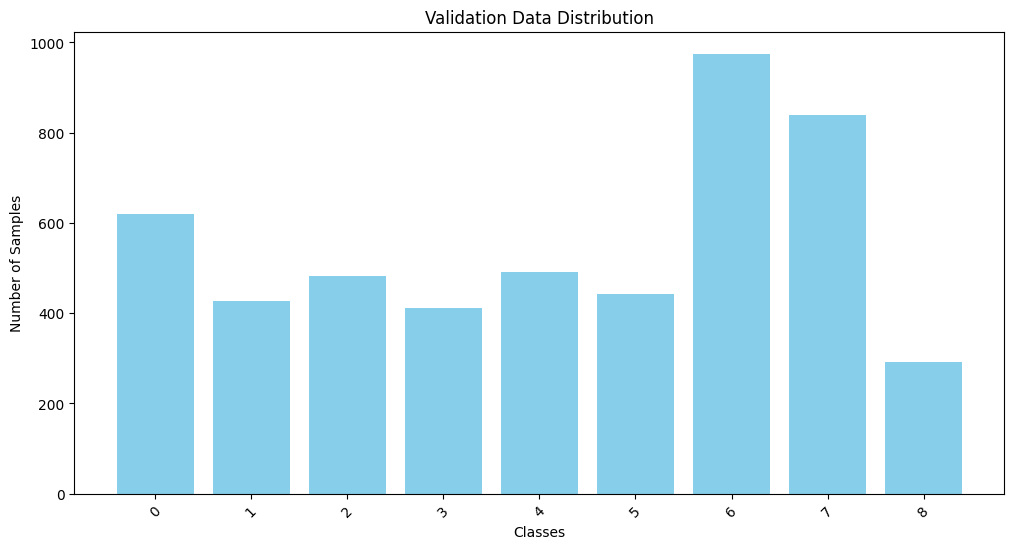

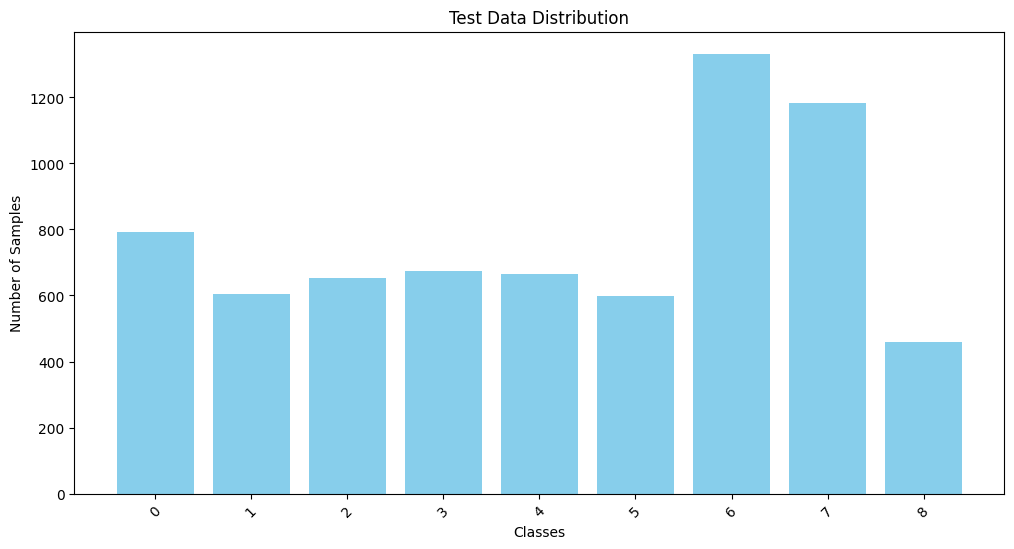

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ phân phối quan sát các lớp trong tập dữ liệu
def plot_distribution(distribution, title):
    classes = list(distribution.keys())
    counts = list(distribution.values())

    plt.figure(figsize=(12, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45)
    plt.show()

# Vẽ biểu đồ phân phối
plot_distribution(train_distribution, "Train Data Distribution")
plot_distribution(val_distribution, "Validation Data Distribution")
plot_distribution(test_distribution, "Test Data Distribution")


# Build Model
#### 1. Base model (ResNet50):

* Mô hình: ResNet50 là một mô hình CNN sâu được thiết kế với kiến trúc residual (hàm dư) để tránh vấn đề gradient biến mất khi huấn luyện mạng sâu.
* `include_top=False`: Chỉ lấy phần trích xuất đặc trưng (feature extractor) của ResNet50, bỏ đi các lớp Fully Connected phía trên để thêm các lớp tùy chỉnh.
* `weights='imagenet'`: Sử dụng trọng số được tiền huấn luyện trên tập ImageNet để tận dụng các đặc trưng học được từ hàng triệu hình ảnh.
* `input_shape=(224, 224, 3)`: Đầu vào là ảnh RGB kích thước 224x224, phù hợp với chuẩn của ResNet50.

#### 2. Các lớp của mô hình tùy chỉnh:

* `GlobalAveragePooling2D()`: Tổng hợp các đặc trưng không gian thành vector duy nhất, giảm số lượng tham số, hạn chế hiện tượng overfitting.
* `Dense(1024, activation='relu')`: Lớp Fully Connected với 1024 nút và hàm kích hoạt ReLU
* `Dropout(0.5)`: Giảm overfitting bằng cách "tắt ngẫu nhiên" 50% các nút trong quá trình huấn luyện.
* Các lớp Dense tiếp theo: `Dense(512, activation='relu')`, `Dense(256, activation='relu')`, `Dense(128, activation='relu')`: Giảm dần số lượng nút trong từng lớp để trích xuất đặc trưng hiệu quả hơn
* `Dense(9, activation='softmax')`: Lớp đầu ra với 9 nút (số lớp phân loại trong bài toán), sử dụng hàm Softmax để tính xác suất cho từng lớp.

In [ ]:
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, LearningRateScheduler

# Callbacks

# Lưu mô hình khi đạt giá trị val_loss nhỏ nhất, tránh ghi đè các phiên bản tốt hơn trước đó.
checkpoint = ModelCheckpoint("model.keras", monitor="val_loss", save_best_only=True, verbose=1)

# Dừng huấn luyện nếu val_loss không cải thiện sau 3 epoch
early_stopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1, restore_best_weights=True)

# Giảm learning_rate nếu val_loss không cải thiện trong 2 epoch liên tiếp
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

callbacks = [checkpoint,reduce_lr,early_stopping]

In [ ]:
learning_rate = 0.0001
epochs = 30

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Xử lý dữ liệu mất cân bằng, cải thiện hiệu năng trên các lớp nhỏ.
# Sử dụng `compute_class_weight` để tính trọng số cân bằng, giúp mô hình tập trung hơn vào các lớp ít mẫu.
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['CategoryID']),
    y=train_df['CategoryID']
)

class_weights_dict = dict(enumerate(class_weights))

In [ ]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2809 - loss: 1.9388
Epoch 1: val_loss improved from inf to 2.27200, saving model to model.keras
348/348 ━━━━━━━━━━━━━━━━━━━━ 685s 2s/step - accuracy: 0.2813 - loss: 1.9379 - val_accuracy: 0.0929 - val_loss: 2.2720 - learning_rate: 1.0000e-04
Epoch 2/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6443 - loss: 1.0378
Epoch 2: val_loss improved from 2.27200 to 1.93790, saving model to model.keras
348/348 ━━━━━━━━━━━━━━━━━━━━ 575s 2s/step - accuracy: 0.6443 - loss: 1.0377 - val_accuracy: 0.2973 - val_loss: 1.9379 - learning_rate: 1.0000e-04
Epoch 3/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7521 - loss: 0.7395
Epoch 3: val_loss improved from 1.93790 to 0.97681, saving model to model.keras
348/348 ━━━━━━━━━━━━━━━━━━━━ 572s 2s/step - accuracy: 0.7521 - loss: 0.7395 - val_accuracy: 0.6848 - val_loss: 0.9768 - learning_rate: 1.0000e-04
Epoch 4/30
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8015 - loss: 0.58

# Testing

In [ ]:
loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {accuracy:.2f}")

109/109 ━━━━━━━━━━━━━━━━━━━━ 92s 848ms/step - accuracy: 0.8203 - loss: 0.6965
Test Accuracy: 0.83


In [ ]:
# save model
model.save('model_resnet50_mlp_split1_v5.h5')

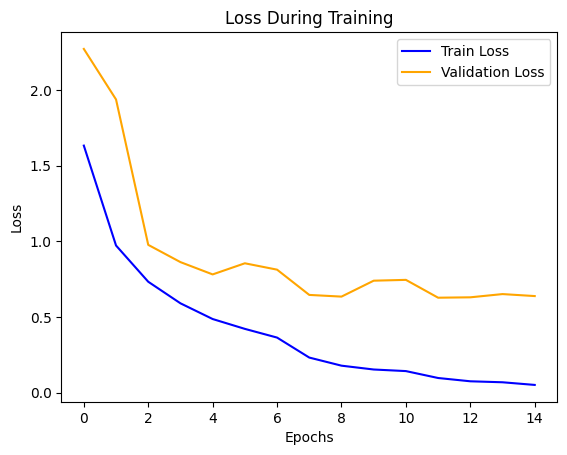

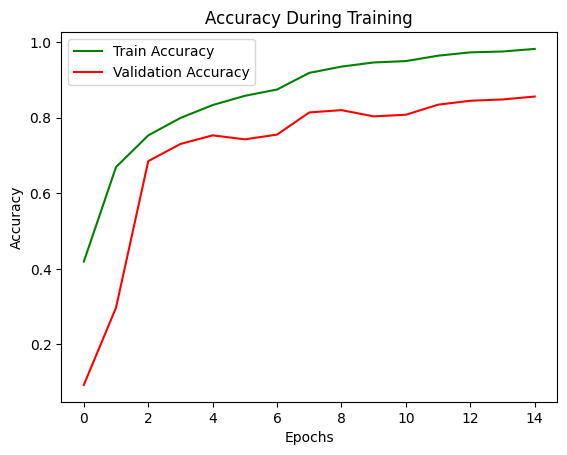

In [ ]:
import matplotlib.pyplot as plt

# Lấy giá trị loss và accuracy từ history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Vẽ biểu đồ loss
# plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Vẽ biểu đồ accuracy
# plt.figure(figsize=(12, 6))
plt.plot(train_accuracy, label='Train Accuracy', color='green')
plt.plot(val_accuracy, label='Validation Accuracy', color='red')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()